In [0]:
pip install GetOldTweets3

In [0]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
from datetime import datetime

#scraping
import GetOldTweets3 as got
import time

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def get_tweets(text_query, start_date, end_date, lang, location, within):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setLang(lang)\
                          .setNear(location)\
                          .setWithin(within)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    tw_df = pd.DataFrame(text_tweets, 
                         columns = ['User', 'Text', 'Date', 'Retweets', 'Favorites', 'HashTags'])
    
    return tw_df

In [0]:
# set attributes needed for get_tweets
text_query = 'psbb'
start_date = '2020-04-28'
end_date = '2020-05-28'
lang = 'id'
within = '50mi'

citys = ['Jakarta, DKI Jakarta','Bogor, Jawa Barat','Bekasi, Jawa Barat','Bandung, Jawa Barat','Depok, Jawa Barat','Tanggerang, Banten','Makassar, Sulawesi Selatan','Sumedang, Jawa Barat','Pekanbaru, Riau','Surabaya, Jawa Timur']
# citys = ['Bandung, Jawa Barat','Depok, Jawa Barat','Tanggerang, Banten','Makassar, Sulawesi Selatan','Sumedang, Jawa Barat','Pekanbaru, Riau','Surabaya, Jawa Timur']

In [0]:
# scrap needed info and export to csv file
for city in citys:
    location = city
    df = get_tweets(text_query, start_date, end_date, lang, location, within)
    df.to_csv(city + '.csv', index = False)
    time.sleep(310)

In [0]:
# add 'City' column and combine all datasets
city_column = ['JKT', 'BGR', 'BKS', 'BDG', 'DPK', 'TGR', 'MKS', 'SMD', 'PKB', 'SBY']
psbb = pd.DataFrame()
for i in range(len(city_column)):
    df = pd.read_csv(citys[i] + '.csv')
    df['City'] = city_column[i]
    psbb = pd.concat([psbb, df], axis = 0)

In [0]:
# export our raw data
psbb.to_csv('psbb.csv', index = False)

In [0]:
# import data
df = pd.read_csv("psbb.csv")
df.shape

(1895, 7)

In [0]:
# remove duplicates
df.replace('[]', np.nan,inplace=True)
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

# devide timestamp into date and time
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].apply( lambda x: x.strftime("%Y-%m-%d"))
df['time'] = df['Date'].apply( lambda x: x.strftime("%H-%M-%S"))
df.drop(['Date'],axis = 1, inplace =True)

# replace city initials with city names
replace_values = {'JKT' : 'Jakarta', 'BGR' : 'Bogor', 'MDN' : 'Medan', 'BDG' : 'Bandung', 'MKS' : 'Makassar',
                  'SMG' : 'Semarang', 'PLM' : 'Palembang', 'BTM' : 'Batam', 'PKB' : 'Pekanbaru', 'MLG' : 'Malang'}                                                                                          
df = df.replace({"City": replace_values})  

In [0]:
from numpy import *

In [0]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
unique_user = pd.DataFrame(df.groupby('date')['Text'].nunique())
lag_user = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis = 1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-18,12,14,1.166667,14,0
2020-05-19,19,25,1.315789,25,0
2020-05-20,15,16,1.066667,16,0
2020-05-21,17,17,1.000000,17,0
2020-05-22,25,26,1.040000,26,0
2020-05-23,59,75,1.271186,75,0
2020-05-24,32,36,1.125000,36,0
2020-05-25,52,74,1.423077,74,0
2020-05-26,62,105,1.693548,105,0


In [0]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]

In [0]:
lag_user

[0,
 0,
 258,
 423,
 545,
 686,
 809,
 956,
 1109,
 1232,
 1393,
 1512,
 1617,
 1771,
 1917,
 2115,
 2241,
 2361,
 2572,
 2717,
 2842,
 2987,
 3168,
 3360,
 5194,
 6937,
 8568,
 9833,
 10506,
 11401]

In [0]:
# select '2020-04-06' as division
# old users: who started to be active before 04-06
# new_users: who weren't active until 04-06

# existing_user= df[df['date'] < '2020-04-11']['User'].unique()
existing_user= df[df['date'] < '2020-04-29']['User'].unique()

# retain all old users
df1 = df[df['User'].isin(existing_user)]                      
df2 = df[-df['User'].isin(existing_user)]

# sample new users
df2 = df2.sample(500)

# get new sample
df = pd.concat([df1,df2])                                     

# export new sample
df.to_csv("DirumahAja_Final.csv", index = False)
df.shape

(544, 8)

[Text(0, 0, '2020-04-28'),
 Text(0, 0, '2020-04-29'),
 Text(0, 0, '2020-04-30'),
 Text(0, 0, '2020-05-01'),
 Text(0, 0, '2020-05-02'),
 Text(0, 0, '2020-05-03'),
 Text(0, 0, '2020-05-04'),
 Text(0, 0, '2020-05-05'),
 Text(0, 0, '2020-05-06'),
 Text(0, 0, '2020-05-07'),
 Text(0, 0, '2020-05-08'),
 Text(0, 0, '2020-05-09'),
 Text(0, 0, '2020-05-10'),
 Text(0, 0, '2020-05-11'),
 Text(0, 0, '2020-05-12'),
 Text(0, 0, '2020-05-13'),
 Text(0, 0, '2020-05-14'),
 Text(0, 0, '2020-05-15'),
 Text(0, 0, '2020-05-16'),
 Text(0, 0, '2020-05-17'),
 Text(0, 0, '2020-05-18'),
 Text(0, 0, '2020-05-19'),
 Text(0, 0, '2020-05-20'),
 Text(0, 0, '2020-05-21'),
 Text(0, 0, '2020-05-22'),
 Text(0, 0, '2020-05-23'),
 Text(0, 0, '2020-05-24'),
 Text(0, 0, '2020-05-25'),
 Text(0, 0, '2020-05-26'),
 Text(0, 0, '2020-05-27')]

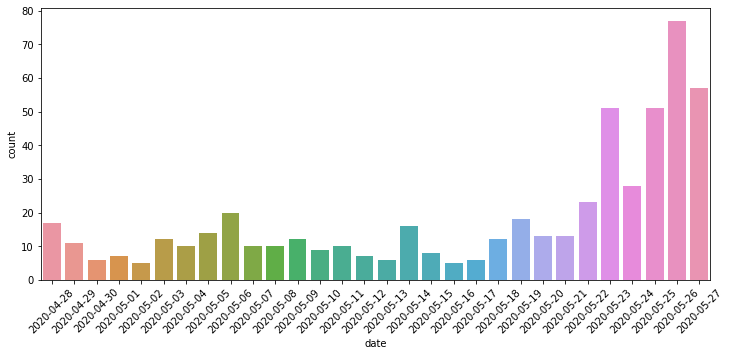

In [0]:
# plot the distribution of our new sample
fig = plt.figure(figsize = (12,5))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

In [0]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis =1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-18,12,12,1.000000,191,3
2020-05-19,15,18,1.200000,200,9
2020-05-20,12,13,1.083333,211,11
2020-05-21,13,13,1.000000,220,9
2020-05-22,22,23,1.045455,232,12
2020-05-23,42,51,1.214286,256,24
2020-05-24,25,28,1.120000,309,53
2020-05-25,38,51,1.342105,334,25
2020-05-26,46,77,1.673913,373,39


In [0]:
df.head()

,User,Text,Retweets,Favorites,HashTags,City,date,time
52,golkar_empat,Pemerintah Siap Kembali Putar Roda Perekonomia...,0,0,#PSBB #NewNormal #indonesianewnormal #Indonesi...,Jakarta,2020-05-27,03-07-55
112,PedroPapakilo,Km 47 arah jakarta padat ada check point #puta...,0,0,#putarbalik #turnback #arusbalik #psbb #Checkp...,Jakarta,2020-05-26,04-16-47
156,PedroPapakilo,TL arah Kalibata dari PGC CONDET CILILITAN PAD...,0,0,#PSBBJakarta #PSBB #psbbbelumdilonggarkan,Jakarta,2020-05-25,10-07-16
170,thediyoon,#mudik dan #pulangkampung terhambat akibat #ps...,0,0,#mudik #pulangkampung #psbb #lebaran #lebaran,Jakarta,2020-05-25,03-46-16
172,thediyoon,#mudik dan #pulangkampung terhambat akibat #ps...,0,0,#mudik #pulangkampung #psbb #lebaran #lebaran,Jakarta,2020-05-25,03-33-10
